In [1]:
import sys
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

sys.path.insert(0, '../CODE/')
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

# Cross-TF validation of K562 cell line

In [2]:
organism = 'human_k562'
output_dir = '../OUTPUT/human_k562/all_feats/'

pred_df = pd.read_csv(output_dir + 'preds.csv.gz')

rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
stats_df = stats_df.merge(rr_df, on='tf')
stats_df = stats_df.dropna()

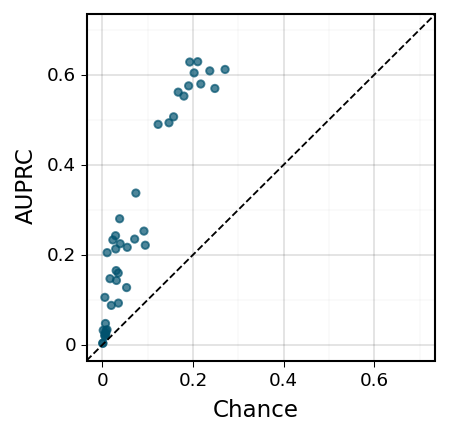

<ggplot: (-9223370592303710334)>

In [3]:
ax = (
    ggplot(stats_df, aes(x='label', y='auprc'))
    + geom_point(color=COLORS['dark_blue'], alpha=.7)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + lims(x=[0, .7], y=[0, .7])
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

display(ax)

ax.save('figures/Human_K562_auprc_v_chance.pdf')

Pearson R=0.449, p=0.003


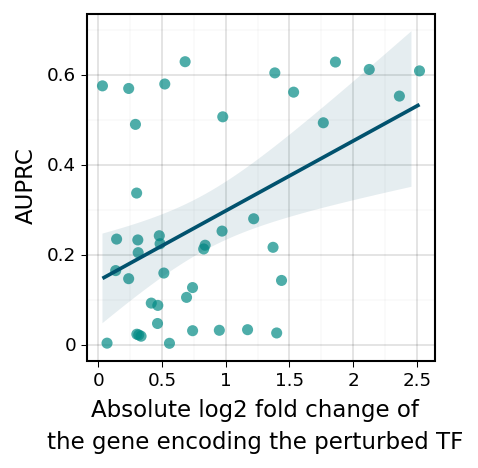

<ggplot: (-9223370592304287891)>

In [4]:
pert_df = pd.read_csv('../RESOURCES/Human_K562_TFPert/deseq2_tf_quality.csv', index_col=0)

plot_df = stats_df.merge(pert_df, how='left', left_on='tf', right_on='tf_ensg')
plot_df['absLog2FoldChange'] = np.abs(plot_df['log2FoldChange'])

r, p = ss.pearsonr(plot_df['absLog2FoldChange'], plot_df['auprc'])
print('Pearson R={:.3f}, p={:.3f}'.format(r, p))

ax = (
    ggplot(plot_df, aes(x='absLog2FoldChange', y='auprc'))
    + geom_point(alpha=.7, size=3, stroke=0, color=COLORS['dark_green'])
    + geom_smooth(method='lm', color=COLORS['dark_blue'], fill=COLORS['dark_blue'], alpha=.1)
    + labs(x='Absolute log2 fold change of\nthe gene encoding the perturbed TF', y='AUPRC')
    + lims(y=[0, .7])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150,
        axis_title=element_text(lineheight=1.5))
)

display(ax)

ax.save('figures/Human_K562_auprc_v_tfpert_quality.pdf')

# Compare regulatory DNA types

In [2]:
organism = 'human_k562'
output_dir_prefix = '../OUTPUT/human_k562/'
regdna_type_dict = {
    'all_feats': 'Enhan + Prom',
    'all_feats_prom_only': 'Prom Only',
    'all_feats_gene_body': 'Gene Body 2Kb',
    'GEXonly': 'GEX Only'
}

pred_df = pd.read_csv(output_dir_prefix + '/all_feats/preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

comb_stats_df = pd.DataFrame()

for regdna_type in regdna_type_dict.keys():
    output_dir = '{}/{}/'.format(output_dir_prefix, regdna_type)
    stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
    stats_df = stats_df.dropna()
    stats_df['regdna_type'] = regdna_type_dict[regdna_type]
    
    comb_stats_df = comb_stats_df.append(stats_df, ignore_index=False)

comb_stats_df['regdna_type'] = pd.Categorical(
    comb_stats_df['regdna_type'], ordered=True,
    categories=['Enhan + Prom', 'Prom Only', 'Gene Body 2Kb', 'GEX Only']
)

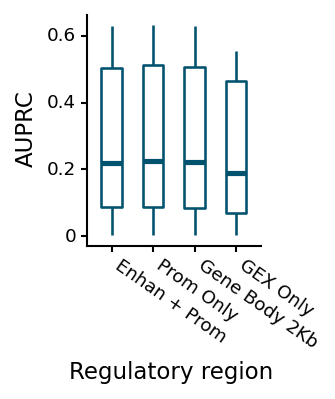

<ggplot: (2989605294975)>

In [3]:
ax = (
    ggplot(comb_stats_df, aes(x='regdna_type', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
#     + geom_jitter(size=.5, alpha=.5, position=position_jitter(width=0.05, height=0), color=COLORS['orange'])
    + xlab('Regulatory region')
    + ylab('AUPRC')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(color='#000000', angle=-35, hjust=0),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_K562_auprc_vs_regdna_types.pdf')

# Compare regulatory feature aggregation strategy

In [5]:
organism = 'human_k562'
output_dir_prefix = '../OUTPUT/human_k562/'
regdna_type_dict = {
    'all_feats': 'Prom + Agg Enhan',
    'all_feats_binned_enhan': 'Prom + Bin Enhan'
}

pred_df = pd.read_csv(output_dir_prefix + '/all_feats/preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

comb_stats_df = pd.DataFrame()

for regdna_type in regdna_type_dict.keys():
    output_dir = '{}/{}/'.format(output_dir_prefix, regdna_type)
    stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
    stats_df = stats_df.dropna()
    stats_df['regdna_type'] = regdna_type_dict[regdna_type]
    
    comb_stats_df = comb_stats_df.append(stats_df, ignore_index=False)

comb_stats_df['regdna_type'] = pd.Categorical(
    comb_stats_df['regdna_type'], ordered=True,
    categories=['Prom + Agg Enhan', 'Prom + Bin Enhan']
)

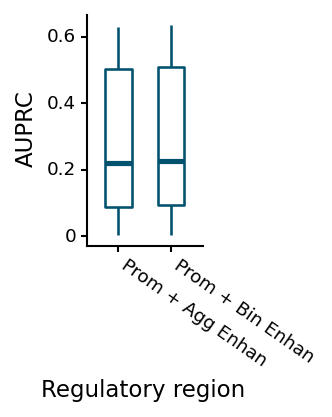

<ggplot: (2986292871558)>

In [6]:
ax = (
    ggplot(comb_stats_df, aes(x='regdna_type', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
#     + geom_jitter(size=.5, alpha=.5, position=position_jitter(width=0.05, height=0), color=COLORS['orange'])
    + xlab('Regulatory region')
    + ylab('AUPRC')
    + theme_classic()
    + theme(figure_size=(1, 2), dpi=150,
           axis_text_x=element_text(color='#000000', angle=-35, hjust=0),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_K562_auprc_vs_regdna_aggregation_strategies.pdf')

# Compare full model, binding only, and GEX only using ratios to random

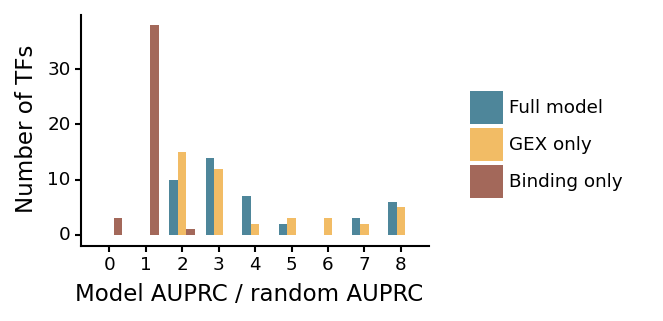

<ggplot: (1462116823858)>

In [51]:
model_types = ['Full model', 'GEX only', 'Binding only']
rtr_df = pd.read_csv('tables/SupplementalTable_K562.csv')[
    ['TF', 'Full model / random', 'GEX / random', 'Binding / random']
].rename(columns={'Full model / random': 'Full model', 'GEX / random': 'GEX only', 'Binding / random': 'Binding only'})
rtr_df = rtr_df.melt(id_vars=['TF'], value_vars=model_types)

# Cap the ratio at 8
rtr_df.loc[rtr_df['value'] > 8, 'value'] = 8.01

# Create histogram bin
cnts, bins = np.histogram(rtr_df.loc[rtr_df['variable'] == 'Full model', 'value'], bins=9, range=(0, 9))
hist_df = pd.DataFrame({'bin': bins[:-1], 'cnt': cnts, 'variable': ['Full model'] * 9})
cnts, bins = np.histogram(rtr_df.loc[rtr_df['variable'] == 'GEX only', 'value'], bins=9, range=(0, 9))
hist_df = hist_df.append(pd.DataFrame({'bin': bins[:-1], 'cnt': cnts, 'variable': ['GEX only'] * 9}), ignore_index=True)
cnts, bins = np.histogram(rtr_df.loc[rtr_df['variable'] == 'Binding only', 'value'], bins=9, range=(0, 9))
hist_df = hist_df.append(pd.DataFrame({'bin': bins[:-1], 'cnt': cnts, 'variable': ['Binding only'] * 9}), ignore_index=True)
hist_df['variable'] = pd.Categorical(hist_df['variable'], ordered=True, categories=model_types)

ax = (
    ggplot(hist_df, aes(x='bin', y='cnt', fill='variable'))
    + geom_bar(stat='identity', position=position_dodge(), width=.7, alpha=.7)
    + scale_fill_manual([COLORS['dark_blue'], COLORS['yellow'], COLORS['dark_red']])
    + labs(x='Model AUPRC / random AUPRC', y='Number of TFs', fill='')
    + scale_x_continuous(breaks=range(0, 9))
    + theme_classic()
    + theme(
        figure_size=(3, 2), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_K562_ratio2random_vs_models.pdf')

# Compare AUCs for full model (enhan + prom) vs chance

In [14]:
organism = 'human_k562'
output_dir_prefix = '../OUTPUT/human_k562/'
data_type_dict = {
    'all_feats': 'K562 Full Model',
}

sys2com_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Human_genome/protein_coding_genes.BioMart.tab', dtype=str)}

comb_stats_df = pd.DataFrame()

# Get chance AUC
pred_df = pd.read_csv(output_dir_prefix + 'all_feats/preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()
rr_df = rr_df.rename(columns={'label': 'auprc'})
rr_df['data_type'] = 'Theoratical Chance'
comb_stats_df = comb_stats_df.append(rr_df, ignore_index=True)

# Get model AUC
for data_type in data_type_dict.keys():
    output_dir = '{}/{}/'.format(output_dir_prefix, data_type)
    stats_df = pd.read_csv(output_dir + 'stats.csv.gz')
    stats_df = stats_df.dropna()
    stats_df['data_type'] = data_type_dict[data_type]
    comb_stats_df = comb_stats_df.append(stats_df, ignore_index=False)

comb_stats_df['tf_full_name'] = comb_stats_df['tf'].apply(lambda x: '{} ({})'.format(x, sys2com_dict[x]))
                                            
# Order groups by data type
comb_stats_df['data_type'] = pd.Categorical(
    comb_stats_df['data_type'], ordered=True,
    categories=['Theoratical Chance', 'K562 Full Model']
)

# Order TFs by max AUC
max_auc_df = comb_stats_df.groupby('tf_full_name')[['auprc']].max().reset_index()

comb_stats_df['tf_full_name'] = pd.Categorical(
    comb_stats_df['tf_full_name'], ordered=True,
    categories=max_auc_df.sort_values('auprc')['tf_full_name'].values
)

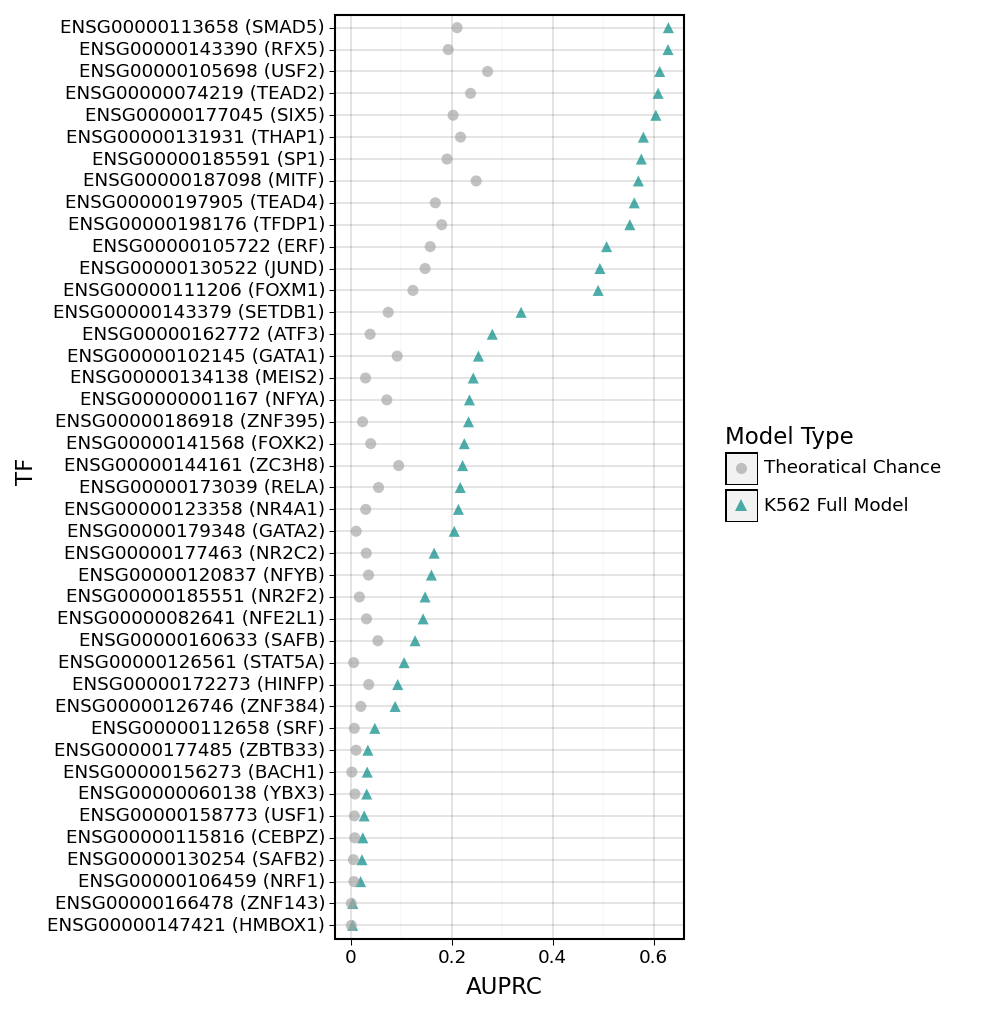

<ggplot: (-9223370600516782006)>

In [15]:
ax = (
    ggplot(comb_stats_df, aes(x='auprc', y='tf_full_name', color='data_type', shape='data_type'))
    + geom_point(alpha=.7, size=3, stroke=0)
    + scale_color_manual([COLORS['grey'], COLORS['dark_green']])
    + labs(x='AUPRC', y='TF', color='Model Type', shape='Model Type')
    + theme_linedraw()
    + theme(figure_size=(3, 8), dpi=150)
)
display(ax)

ax.save('figures/Human_K562_auprc_vs_regdna_types_indiv_tfs.pdf')

# Net influence calculated using SHAP values

- Distribution across TFs of the “net influence” of each feature on predictions, averaged over responsive targets. 
- Net influence is the sum of all SHAP values for a feature, regardless of sign or genomic position.

In [5]:
tfs = np.loadtxt('../RESOURCES/TF_list/Human_ENCODE_K562_TFs.txt', dtype=str, usecols=[0])

sss_df = pd.DataFrame()

for i, tf_chunk in enumerate(np.array_split(tfs, 4)):
    print('Working on TF chunk {}, n={}'.format(i, len(tf_chunk)))
    
    sss_subdf = calculate_resp_and_unresp_signed_shap_sum(output_dir, organism=organism, tfs=tf_chunk)
    sss_df = sss_df.append(sss_subdf)

sss_df.to_csv(output_dir + 'signed_shap_sum.csv.gz')

Working on TF chunk 0, n=14
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 1, n=14
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 2, n=13
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 3, n=13
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...


In [6]:
sss_df = pd.read_csv(output_dir + 'signed_shap_sum.csv.gz')

sss_df = sss_df.merge(stats_df[['tf', 'auprc']], on='tf', how='left')
net_inf_df = calculate_shap_net_influence(sss_df)

Significant TFs (n=42)


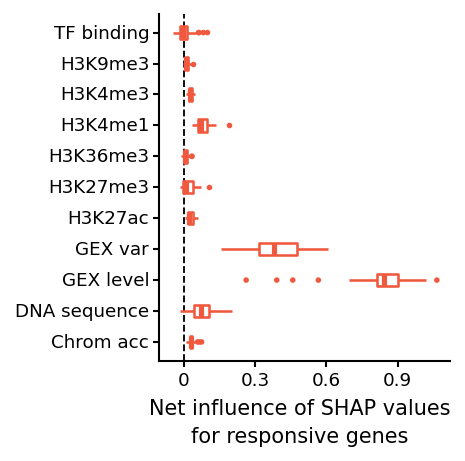

<ggplot: (-9223370605123595751)>

In [7]:
# Plot models that are significant over random permutation
perm_df = pd.read_csv('tables/SupplementalTable_K562.csv')
perm_df['TF_ensg'] = perm_df['TF'].apply(lambda x: x.split(' ')[0])
sig_tfs = perm_df.loc[perm_df['For SHAP analysis'], 'TF_ensg']

plot_df = net_inf_df[(net_inf_df['label_name'] == 'Responsive') & (net_inf_df['tf'].isin(sig_tfs))]
print('Significant TFs (n={})'.format(len(plot_df['tf'].unique())))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(outlier_size=.5, size=.7, width=.4, color=COLORS['orange'])
#     + geom_jitter(height=0, width=.2, alpha=.2, color='blue')
    + coord_flip()
#     + ylim(-.1, 1.6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)

display(ax)

ax.save('figures/Human_K562_net_influence.pdf')

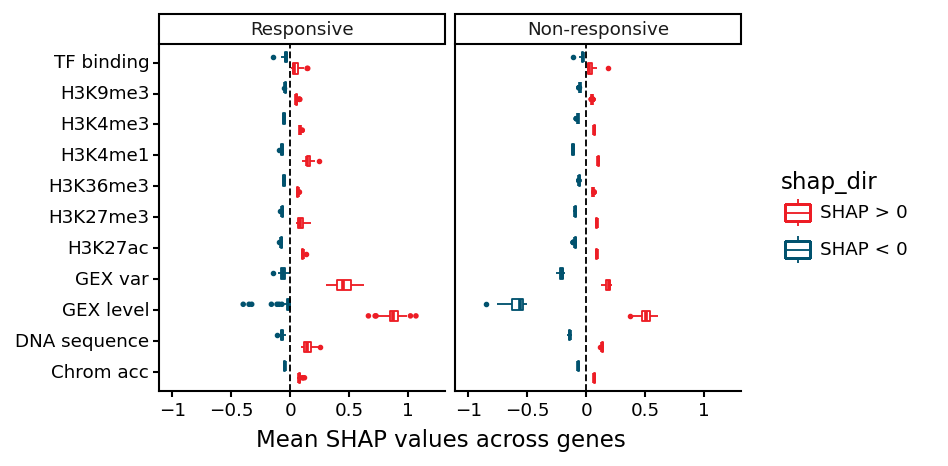

<ggplot: (1458573851512)>

In [17]:
sss_df['shap_dir'] = pd.Categorical(sss_df['shap_dir'], ordered=True, categories=['SHAP > 0', 'SHAP < 0'])
sss_df['label_name'] = pd.Categorical(sss_df['label_name'], ordered=True, categories=['Responsive', 'Non-responsive'])

ax = (
    ggplot(sss_df, aes(x='feat_type_name', y='shap', color='shap_dir'))
    + geom_boxplot(alpha=.8, outlier_size=.5)
    + geom_hline(aes(yintercept=0), linetype='dashed')
    + scale_color_manual([COLORS['red'], COLORS['dark_blue']])
    + coord_flip()
    + facet_wrap('label_name')
    + labs(x=None, y='Mean SHAP values across genes')
    + ylim(-1, 1.2)
    + theme_classic()
    + theme(
        figure_size=(5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Human_K562_pos_neg_influence.pdf')

# Net influence comparing full model vs no GEX feature model vs TF binding only

In [5]:
tfs = np.loadtxt('../RESOURCES/TF_list/Human_ENCODE_K562_TFs.txt', dtype=str, usecols=[0])
output_dir = '../OUTPUT/human_k562/noGEX/'

sss_df = pd.DataFrame()

for i, tf_chunk in enumerate(np.array_split(tfs, 4)):
    print('Working on TF chunk {}, n={}'.format(i, len(tf_chunk)))
    
    sss_subdf = calculate_resp_and_unresp_signed_shap_sum(output_dir, organism=organism, tfs=tf_chunk)
    sss_df = sss_df.append(sss_subdf)

sss_df.to_csv(output_dir + 'signed_shap_sum.csv.gz')

Working on TF chunk 0, n=14
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 1, n=14
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 2, n=13
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 3, n=13
Loading feature data ... 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Parsing signed shap values ...
Summing shap ...


In [3]:
tfs = np.loadtxt('../RESOURCES/TF_list/Human_ENCODE_K562_TFs.txt', dtype=str, usecols=[0])
output_dir = '../OUTPUT/human_k562/bindingonly/'

sss_df = pd.DataFrame()

for i, tf_chunk in enumerate(np.array_split(tfs, 4)):
    print('Working on TF chunk {}, n={}'.format(i, len(tf_chunk)))
    
    sss_subdf = calculate_resp_and_unresp_signed_shap_sum(output_dir, organism=organism, tfs=tf_chunk)
    sss_df = sss_df.append(sss_subdf)

sss_df.to_csv(output_dir + 'signed_shap_sum.csv.gz')

Working on TF chunk 0, n=11
Loading feature data ... 0 1 2 3 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 1, n=11
Loading feature data ... 0 1 2 3 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 2, n=10
Loading feature data ... 0 1 2 3 
Parsing signed shap values ...
Summing shap ...
Working on TF chunk 3, n=10
Loading feature data ... 0 1 2 3 
Parsing signed shap values ...
Summing shap ...


In [37]:
net_inf_df = pd.DataFrame()

sss_df = pd.read_csv('../OUTPUT/human_k562/all_feats/signed_shap_sum.csv.gz')
net_inf_subdf = calculate_shap_net_influence(sss_df)
net_inf_subdf['model_type'] = 'Full Model'
net_inf_df = net_inf_df.append(net_inf_subdf, ignore_index=True)

sss_df = pd.read_csv('../OUTPUT/human_k562/noGEX/signed_shap_sum.csv.gz')
net_inf_subdf = calculate_shap_net_influence(sss_df)
net_inf_subdf['model_type'] = 'Full Model w/o GEX'
net_inf_df = net_inf_df.append(net_inf_subdf, ignore_index=True)

sss_df = pd.read_csv('../OUTPUT/human_k562/bindingonly/signed_shap_sum.csv.gz')
net_inf_subdf = calculate_shap_net_influence(sss_df)
net_inf_subdf['model_type'] = 'TF Binding Only'
net_inf_df = net_inf_df.append(net_inf_subdf, ignore_index=True)

Significant TFs (n=42)


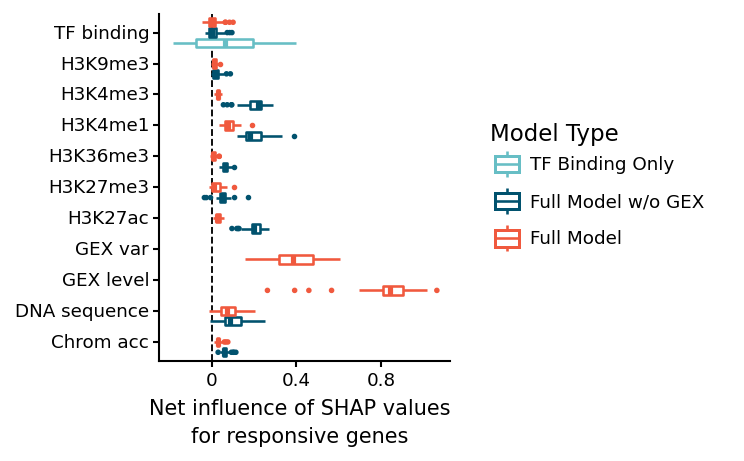

<ggplot: (2946727584071)>

In [46]:
# Plot models that are significant over random permutation
perm_df = pd.read_csv('tables/SupplementalTable_K562.csv')
perm_df['TF_ensg'] = perm_df['TF'].apply(lambda x: x.split(' ')[0])
sig_tfs = perm_df.loc[perm_df['For SHAP analysis'], 'TF_ensg']

plot_df = net_inf_df[(net_inf_df['label_name'] == 'Responsive') & (net_inf_df['tf'].isin(sig_tfs))]
plot_df['model_type'] = pd.Categorical(
    plot_df['model_type'], ordered=True,
    categories=['TF Binding Only', 'Full Model w/o GEX', 'Full Model']
)
print('Significant TFs (n={})'.format(len(plot_df['tf'].unique())))

ax = (
    ggplot(plot_df, aes(x='feat_type_name', y='shap_diff', color='model_type'))
    + geom_hline(yintercept=0, linetype='dashed')
    + geom_boxplot(position=position_dodge(1, preserve="single"), outlier_size=.5, size=.7, width=.8)
    + scale_color_manual([COLORS['light_green'], COLORS['dark_blue'], COLORS['orange']])
    + coord_flip()
#     + ylim(-.1, 1.6)
    + labs(x=None, y='Net influence of SHAP values\nfor responsive genes', color='Model Type')
    + theme_classic()
    + theme(
        figure_size=(2.5, 3), dpi=150,
        axis_text_x=element_text(color='#000000'),
        axis_text_y=element_text(color='#000000'),
        axis_title=element_text(size=10, lineheight=1.5))
)

display(ax)

ax.save('figures/Human_K562_net_influence_full_vs_noGEX_vs_bindingonly.pdf')